In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
import nltk
import emoji
import pickle
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from autocorrect import Speller
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import PorterStemmer,LancasterStemmer,SnowballStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,PowerTransformer,StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Data Collection

In [2]:
data = pd.read_csv(r"C:\Users\pavan\Data_Science_Internship\Tasks\Task 6 - Sentiment Analysis Flipkart Reviews\reviews_data_dump\reviews_badminton\data.csv")

df = data.copy()

df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


### EDA Before Pre-Processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [4]:
def create_class_variables(row):
    if row['Ratings'] >= 4:
        return 'Positive'
    else:
        return 'Negative'

df['sentiment'] = df.apply(create_class_variables, axis=1)

In [5]:
df.drop(columns= ['Reviewer Name','Review Title','Place of Review','Up Votes','Down Votes','Month','Ratings'], axis= 1, inplace= True)

In [6]:
df.head()

,Review text,sentiment
0,"Nice product, good quality, but price is now r...",Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,Negative
2,Worst product. Damaged shuttlecocks packed in ...,Negative
3,"Quite O. K. , but nowadays the quality of the...",Negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,Negative


In [7]:
df.isnull().sum() / len(df) * 100

Review text    0.093919
sentiment      0.000000
dtype: float64

In [8]:
df.dropna(subset= 'Review text',inplace= True)

df.reset_index(drop= True, inplace= True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8510 entries, 0 to 8509
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review text  8510 non-null   object
 1   sentiment    8510 non-null   object
dtypes: object(2)
memory usage: 133.1+ KB


In [10]:
df.duplicated().sum()

3456

In [11]:
df.drop_duplicates(inplace= True)

df.reset_index(drop= True, inplace= True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review text  5054 non-null   object
 1   sentiment    5054 non-null   object
dtypes: object(2)
memory usage: 79.1+ KB


In [13]:
df['sentiment'].value_counts()

Positive    3716
Negative    1338
Name: sentiment, dtype: int64

In [14]:
def EDA_1(data):

    case = " ".join(data).islower()
    html = data.apply(lambda x:True if re.search("<.+?>",x) else False).sum()
    url = data.apply(lambda x:True if re.search("http[s]?://.+? +",x) else False).sum()
    unwanted = data.apply(lambda x:True if re.search("[^a-z\s]",x) else False).sum()

    count = 0
    for sen in data:
        for char in sen.split():
            if emoji.is_emoji(char):
                count += 1

    if case == False:
        print("Contains uppercase letters")
    else:
        print('All are in lowercase letters')

    if html > 0:
        print("Contains html tags")
    else:
        print('No html tags')

    if url > 0:
        print("Contains urls")
    else:
        print('No urls')

    if unwanted > 0:
        print("Contains unwanted characters")
    else:
        print('No unwanted characters')

    if count > 0:
        print('Contains Emoji')
    else:
        print('No Emoji')

In [15]:
EDA_1(df['Review text'])

Contains uppercase letters
No html tags
No urls
Contains unwanted characters
Contains Emoji


In [16]:
feature_var = df['Review text']

feature_var.head()

0    Nice product, good quality, but price is now r...
1    They didn't supplied Yonex Mavis 350. Outside ...
2    Worst product. Damaged shuttlecocks packed in ...
3    Quite O. K. , but nowadays  the quality of the...
4    Over pricedJust â?¹620 ..from retailer.I didn'...
Name: Review text, dtype: object

In [17]:
class_var = df['sentiment']

class_var.head()

0    Positive
1    Negative
2    Negative
3    Negative
4    Negative
Name: sentiment, dtype: object

In [18]:
x_train, x_test, y_train, y_test = train_test_split(feature_var, class_var, random_state= 18, test_size= 0.2, stratify= class_var)

x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, random_state= 18, test_size= 0.2, stratify= y_train)

### Data Pre-Processing

In [19]:
def emoji_remove(x):
    
    return x.apply(lambda x : emoji.demojize(x))

def decontration(x):
    
    x = x.apply(lambda x:re.sub(r"aren't", 'are not', x))
    x = x.apply(lambda x:re.sub(r"won't", 'will not', x))
    x = x.apply(lambda x:re.sub(r"doesn't", 'does not', x))
    x = x.apply(lambda x:re.sub(r"n\'t", " not", x))
    x = x.apply(lambda x:re.sub(r"\'s", " is", x))
    x = x.apply(lambda x:re.sub(r"\'d", " would", x))
    x = x.apply(lambda x:re.sub(r"\'ll", " will", x))
    x = x.apply(lambda x:re.sub(r"\'t", " not", x))
    x = x.apply(lambda x:re.sub(r"\'ve", " have", x))
    x = x.apply(lambda x:re.sub(r"\'m", " am", x))

    return x

def lowercase(x):
    
    return x.str.lower()

def html_tags(x):
    
    return x.apply(lambda x:re.sub("<.+?>"," ",x))

def urls(x):
    
    return x.apply(lambda x:re.sub("https[s]?://.+? +"," ",x))

def unwanted_characters(x):
    
    return x.apply(lambda x:re.sub("[^a-z\s]"," ",x))

def lemmatization(x):
    
    list_stp = stopwords.words("english")
    wl = WordNetLemmatizer()

    def lemmatize_text(text):
        
        words = word_tokenize(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]

        return " ".join(lemmatized_words)

    return x.apply(lemmatize_text)

In [20]:
preprocesser_pipe = Pipeline([("Emoji's", FunctionTransformer(emoji_remove)),
                              ('Decontration',FunctionTransformer(decontration)),
                              ('Lowercase', FunctionTransformer(lowercase)),
                              ('Html_Tags', FunctionTransformer(html_tags)),
                              ('Urls', FunctionTransformer(urls)),
                              ('Unwanted Characters', FunctionTransformer(unwanted_characters)),
                              ('Lemmatization',FunctionTransformer(lemmatization))])

In [21]:
cleaned_x_train = preprocesser_pipe.fit_transform(x_train)

cleaned_x_train = pd.DataFrame(cleaned_x_train)

EDA_1(cleaned_x_train['Review text'])

All are in lowercase letters
No html tags
No urls
No unwanted characters
No Emoji


### EDA After Pre-Processing

In [22]:
eda_data = pd.concat([cleaned_x_train, y_train],axis=1)

eda_data.head()

,Review text,sentiment
4674,good genuine read,Positive
1381,nice product advance deliveryread,Positive
3037,quality pack super awesome read,Positive
4683,poor quality use intermediate n advance player...,Positive
2057,good original genuine yonex mavis slow product...,Positive


In [23]:
grouped_data = eda_data.groupby('sentiment')

positive_rows = grouped_data.get_group('Positive')['Review text']
negative_rows = grouped_data.get_group('Negative')['Review text']

positive_text = " ".join(positive_rows)
negative_text = " ".join(negative_rows)

positive_review_words = " ".join(positive_rows).split()
negative_review_words = " ".join(negative_rows).split()

print('Total number of words in positive reviews : ',len(positive_review_words))
print('Total number of words in positive reviews : ',len(negative_review_words))

Total number of words in positive reviews :  12303
Total number of words in positive reviews :  5413


In [24]:
positive_words = []
negative_words = []

for word in positive_review_words:
    if word not in negative_review_words:
        positive_words.append(word)

for word in negative_review_words:
    if word not in positive_review_words:
        negative_words.append(word)

In [25]:
Counter(positive_words).most_common(10)

[('priceread', 43),
 ('superb', 35),
 ('amaze', 18),
 ('timely', 15),
 ('still', 15),
 ('bestread', 14),
 ('deal', 13),
 ('fantastic', 12),
 ('suit', 12),
 ('grin', 11)]

In [26]:
Counter(negative_words).most_common(10)

[('sell', 10),
 ('cheat', 9),
 ('tear', 9),
 ('rotate', 8),
 ('hole', 6),
 ('useless', 6),
 ('usually', 5),
 ('change', 4),
 ('cut', 4),
 ('instead', 4)]

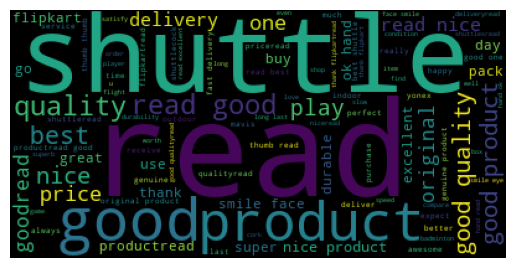

In [27]:
wc = WordCloud().generate(positive_text)
plt.imshow(wc)
plt.axis("off")
plt.show()

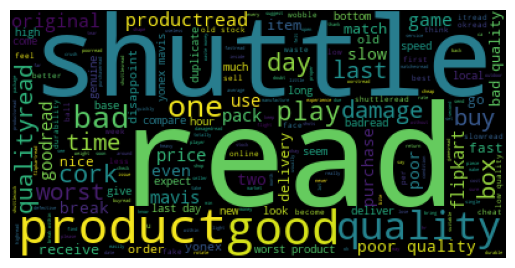

In [28]:
wc = WordCloud().generate(negative_text)
plt.imshow(wc)
plt.axis("off")
plt.show()

In [29]:
x_train.head()

4674                          Good and genuine .READ MORE
1381               Nice product advance deliveryREAD MORE
3037     quality and packing is super awesome...READ MORE
4683    Poor quality, no use for intermediate n advanc...
2057    It's good,original genuine yonex Mavis 350 slo...
Name: Review text, dtype: object

In [30]:
y_train.head()

4674    Positive
1381    Positive
3037    Positive
4683    Positive
2057    Positive
Name: sentiment, dtype: object

### Feature Engineering

In [31]:
bow_pipeline = Pipeline([('Pre-Processing',preprocesser_pipe),('Bag of Words', CountVectorizer()),('Normalization', StandardScaler(with_mean= False))])

bbow_pipeline = Pipeline([('Pre-Processing',preprocesser_pipe), ('Binary Bag of Words', CountVectorizer(binary= True))])

tfidf_pipeline = Pipeline([('Pre-Processing',preprocesser_pipe), ('Tf-Idf',TfidfVectorizer()), ('Normalization', StandardScaler(with_mean= False))])

bow_x_train = bow_pipeline.fit_transform(x_train)
bow_x_cv = bow_pipeline.transform(x_cv)
bow_x_test = bow_pipeline.transform(x_test)

bbow_x_train = bbow_pipeline.fit_transform(x_train)
bbow_x_cv = bbow_pipeline.transform(x_cv)
bbow_x_test = bbow_pipeline.transform(x_test)

tfidf_x_train = tfidf_pipeline.fit_transform(x_train)
tfidf_x_cv = tfidf_pipeline.transform(x_cv)
tfidf_x_test = tfidf_pipeline.transform(x_test)

## Model Selection

### KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier()

param_grid = { 'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49],
               'p' : [1,2,3] }

clf_knn = GridSearchCV(knn, param_grid= param_grid, cv= 8, scoring = "accuracy")

clf_knn.fit(bow_x_train, y_train)

clf_knn.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
192 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 562, in _fit
    raise ValueError(
ValueError: Metric 'minkowski' not valid for sparse i

{'n_neighbors': 9, 'p': 1}

In [33]:
knn_best_params = clf_knn.best_params_

knn = KNeighborsClassifier(n_neighbors= knn_best_params['n_neighbors'], p= knn_best_params['p'])

model_knn = knn.fit(bow_x_train, y_train)

y_pred = model_knn.predict(bow_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.78      0.29      0.42       214
    Positive       0.79      0.97      0.87       595

    accuracy                           0.79       809
   macro avg       0.78      0.63      0.65       809
weighted avg       0.79      0.79      0.75       809



In [34]:
knn = KNeighborsClassifier()

param_grid = { 'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49],
               'p' : [1,2,3] }

clf_knn = GridSearchCV(knn, param_grid= param_grid, cv= 8, scoring = "accuracy")

clf_knn.fit(bbow_x_train, y_train)

clf_knn.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
192 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 562, in _fit
    raise ValueError(
ValueError: Metric 'minkowski' not valid for sparse i

{'n_neighbors': 13, 'p': 1}

In [35]:
knn_best_params = clf_knn.best_params_

knn = KNeighborsClassifier(n_neighbors= knn_best_params['n_neighbors'], p= knn_best_params['p'])

model_knn = knn.fit(bbow_x_train, y_train)

y_pred = model_knn.predict(bbow_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.78      0.32      0.45       214
    Positive       0.80      0.97      0.87       595

    accuracy                           0.80       809
   macro avg       0.79      0.64      0.66       809
weighted avg       0.79      0.80      0.76       809



In [36]:
knn = KNeighborsClassifier()

param_grid = { 'n_neighbors': [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49],
               'p' : [1,2,3] }

clf_knn = GridSearchCV(knn, param_grid= param_grid, cv= 8, scoring = "accuracy")

clf_knn.fit(tfidf_x_train, y_train)

clf_knn.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
192 fits failed out of a total of 576.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
192 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 562, in _fit
    raise ValueError(
ValueError: Metric 'minkowski' not valid for sparse i

{'n_neighbors': 9, 'p': 2}

In [37]:
knn_best_params = clf_knn.best_params_

knn = KNeighborsClassifier(n_neighbors= knn_best_params['n_neighbors'], p= knn_best_params['p'])

model_knn = knn.fit(tfidf_x_train, y_train)

y_pred = model_knn.predict(tfidf_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.84      0.31      0.46       214
    Positive       0.80      0.98      0.88       595

    accuracy                           0.80       809
   macro avg       0.82      0.65      0.67       809
weighted avg       0.81      0.80      0.77       809



### Naive Bayes

In [38]:
multi = MultinomialNB()

param_grid = { 'alpha': [0.1, 0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]}

clf_naive = GridSearchCV(multi, param_grid= param_grid, cv= 8, scoring= 'accuracy')

clf_naive.fit(bow_x_train, y_train)

clf_naive.best_params_

{'alpha': 0.5}

In [39]:
naive_best_params = clf_naive.best_params_

multi = MultinomialNB(alpha= naive_best_params['alpha'])

model_naive = multi.fit(bow_x_train, y_train)

y_pred = model_naive.predict(bow_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.64      0.65      0.65       214
    Positive       0.87      0.87      0.87       595

    accuracy                           0.81       809
   macro avg       0.76      0.76      0.76       809
weighted avg       0.81      0.81      0.81       809



In [40]:
multi = MultinomialNB()

param_grid = { 'alpha': [0.1, 0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]}

clf_naive = GridSearchCV(multi, param_grid= param_grid, cv= 8, scoring= 'accuracy')

clf_naive.fit(tfidf_x_train, y_train)

clf_naive.best_params_

{'alpha': 0.1}

In [41]:
naive_best_params = clf_naive.best_params_

multi = MultinomialNB(alpha= naive_best_params['alpha'])

model_naive = multi.fit(tfidf_x_train, y_train)

y_pred = model_naive.predict(tfidf_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.63      0.65      0.64       214
    Positive       0.87      0.86      0.87       595

    accuracy                           0.81       809
   macro avg       0.75      0.76      0.75       809
weighted avg       0.81      0.81      0.81       809



In [42]:
bernouli = BernoulliNB()

param_grid = { 'alpha': [0.1, 0.5, 1.0, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0]}

clf_naive = GridSearchCV(bernouli, param_grid= param_grid, cv= 8, scoring= 'accuracy')

clf_naive.fit(bbow_x_train, y_train)

clf_naive.best_params_

{'alpha': 0.1}

In [43]:
naive_best_params = clf_naive.best_params_

bernouli = BernoulliNB(alpha= naive_best_params['alpha'])

model_naive = bernouli.fit(bbow_x_train, y_train)

y_pred = model_naive.predict(bbow_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.75      0.57      0.65       214
    Positive       0.86      0.93      0.89       595

    accuracy                           0.84       809
   macro avg       0.80      0.75      0.77       809
weighted avg       0.83      0.84      0.83       809



### LogisticRegression

In [44]:
logistic = LogisticRegression( )

parameters = { 'penalty': ['l1', 'l2', 'elasticnet'],
               'C': [0.001, 0.01, 0.1,0.5,0.8, 1.1, 1.5 , 1, 10, 100],
               'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] }

clf_log = GridSearchCV(logistic, param_grid= parameters,cv= 8, scoring= 'accuracy')

clf_log.fit(bow_x_train, y_train)

clf_log.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packag

{'C': 0.01, 'l1_ratio': 0.1, 'penalty': 'l2'}

In [45]:
log_best_params = clf_log.best_params_

logistic = LogisticRegression(penalty= log_best_params['penalty'],
                              C= log_best_params['C'],
                              l1_ratio= log_best_params['l1_ratio'])

log_model = logistic.fit(bow_x_train, y_train)

y_pred = log_model.predict(bow_x_cv)

print(classification_report(y_cv, y_pred))

              precision    recall  f1-score   support

    Negative       0.76      0.56      0.64       214
    Positive       0.85      0.94      0.89       595

    accuracy                           0.84       809
   macro avg       0.81      0.75      0.77       809
weighted avg       0.83      0.84      0.83       809



C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


In [ ]:
logistic = LogisticRegression( )

parameters = { 'penalty': ['l1', 'l2', 'elasticnet'],
               'C': [0.001, 0.01, 0.1,0.5,0.8, 1.1, 1.5 , 1, 10, 100],
               'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] }

clf_log = GridSearchCV(logistic, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_log.fit(bbow_x_train, y_train)

clf_log.best_params_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packag

In [ ]:
log_best_params = clf_log.best_params_

logistic = LogisticRegression(penalty= log_best_params['penalty'],
                              C= log_best_params['C'],
                              l1_ratio= log_best_params['l1_ratio'])

log_model = logistic.fit(bbow_x_train, y_train)

y_pred = log_model.predict(bbow_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
logistic = LogisticRegression( )

parameters = { 'penalty': ['l1', 'l2', 'elasticnet'],
               'C': [0.001, 0.01, 0.1,0.5,0.8, 1.1, 1.5 , 1, 10, 100],
               'l1_ratio' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] }

clf_log = GridSearchCV(logistic, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_log.fit(tfidf_x_train, y_train)

clf_log.best_params_

In [ ]:
log_best_params = clf_log.best_params_

logistic = LogisticRegression(penalty= log_best_params['penalty'],
                              C= log_best_params['C'],
                              l1_ratio= log_best_params['l1_ratio'])

log_model = logistic.fit(tfidf_x_train, y_train)

y_pred = log_model.predict(tfidf_x_cv)

print(classification_report(y_cv, y_pred))

### 5. Support Vector Machine

In [ ]:
svm = SVC()

parameters = { 'C': [0.1,0.4, 0.6, 0.9, 3, 6, 1],
               'kernel': ['linear'],
               'coef0': [0.0, 0.1, 0.4]}

clf_svm = GridSearchCV(svm, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_svm.fit(bow_x_train, y_train)

clf_svm.best_params_

In [ ]:
svm_best_params = clf_svm.best_params_

svm = SVC(C= svm_best_params['C'], kernel= svm_best_params['kernel'], coef0= svm_best_params['coef0'])

model_svm = svm.fit(bow_x_train, y_train)

y_pred = model_svm.predict(bow_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
svm = SVC()

parameters = { 'C': [0.1,0.4, 0.6, 0.9, 3, 6, 1],
               'kernel': ['linear'],
               'coef0': [0.0, 0.1, 0.4]}

clf_svm = GridSearchCV(svm, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_svm.fit(bbow_x_train, y_train)

clf_svm.best_params_

In [ ]:
svm_best_params = clf_svm.best_params_

svm = SVC(C= svm_best_params['C'], kernel= svm_best_params['kernel'], coef0= svm_best_params['coef0'])

model_svm = svm.fit(bbow_x_train, y_train)

y_pred = model_svm.predict(bbow_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
svm = SVC()

parameters = { 'C': [0.1,0.4, 0.6, 0.9, 3, 6, 1],
               'kernel': ['linear'],
               'coef0': [0.0, 0.1, 0.4]}

clf_svm = GridSearchCV(svm, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_svm.fit(tfidf_x_train, y_train)

clf_svm.best_params_

In [ ]:
svm_best_params = clf_svm.best_params_

svm = SVC(C= svm_best_params['C'], kernel= svm_best_params['kernel'], coef0= svm_best_params['coef0'])

model_svm = svm.fit(tfidf_x_train, y_train)

y_pred = model_svm.predict(tfidf_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
rfc = RandomForestClassifier()

parameters = {  'n_estimators': [20, 30,25],
                'criterion' : ['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'] }

clf_rfc = GridSearchCV(rfc, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_rfc.fit(bow_x_train, y_train)

clf_rfc.best_params_

In [ ]:
rfc_best_params = clf_rfc.best_params_

rfc = RandomForestClassifier(n_estimators= rfc_best_params['n_estimators'],
                            criterion= rfc_best_params['criterion'],
                            max_depth= rfc_best_params['max_depth'],
                            min_samples_split= rfc_best_params['min_samples_split'],
                            min_samples_leaf= rfc_best_params['min_samples_leaf'],
                            max_features= rfc_best_params['max_features'])

rfc_model = rfc.fit(bow_x_train, y_train)

y_pred = rfc_model.predict(bow_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
rfc = RandomForestClassifier()

parameters = {  'n_estimators': [20, 30,25],
                'criterion' : ['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'] }

clf_rfc = GridSearchCV(rfc, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_rfc.fit(bbow_x_train, y_train)

clf_rfc.best_params_

In [ ]:
rfc_best_params = clf_rfc.best_params_

rfc = RandomForestClassifier(n_estimators= rfc_best_params['n_estimators'],
                            criterion= rfc_best_params['criterion'],
                            max_depth= rfc_best_params['max_depth'],
                            min_samples_split= rfc_best_params['min_samples_split'],
                            min_samples_leaf= rfc_best_params['min_samples_leaf'],
                            max_features= rfc_best_params['max_features'])

rfc_model = rfc.fit(bbow_x_train, y_train)

y_pred = rfc_model.predict(bbow_x_cv)

print(classification_report(y_cv, y_pred))

In [ ]:
rfc = RandomForestClassifier()

parameters = {  'n_estimators': [20, 30,25],
                'criterion' : ['gini', 'entropy', 'log_loss'],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'] }

clf_rfc = GridSearchCV(rfc, param_grid= parameters, cv= 8, scoring= 'accuracy')

clf_rfc.fit(tfidf_x_train, y_train)

clf_rfc.best_params_

In [ ]:
rfc_best_params = clf_rfc.best_params_

rfc = RandomForestClassifier(n_estimators= rfc_best_params['n_estimators'],
                            criterion= rfc_best_params['criterion'],
                            max_depth= rfc_best_params['max_depth'],
                            min_samples_split= rfc_best_params['min_samples_split'],
                            min_samples_leaf= rfc_best_params['min_samples_leaf'],
                            max_features= rfc_best_params['max_features'])

rfc_model = rfc.fit(tfidf_x_train, y_train)

y_pred = rfc_model.predict(tfidf_x_cv)

print(classification_report(y_cv, y_pred))

### Model Evalution

In [ ]:
naive_best_params = clf_naive.best_params_

bernouli = BernoulliNB(alpha= 0.1)

model_naive = bernouli.fit(bbow_x_train, y_train)

y_pred = model_naive.predict(bbow_x_test)

print(classification_report(y_test, y_pred))

In [ ]:
pickle.dump(bbow_pipeline, open(r"C:\Users\pavan\Data_Science_Internship\Tasks\Task 6 - Sentiment Analysis Flipkart Reviews\Pre-Processing_Pipe.pkl",'wb'))

In [ ]:
pickle.dump(bernouli, open(r"C:\Users\pavan\Data_Science_Internship\Tasks\Task 6 - Sentiment Analysis Flipkart Reviews\Model.pkl", 'wb'))